# Intel Tech Week workshop: Introduction to Deep Learning with Python
# Hands-on session
### Itay lieder

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
# for handeling data frames
import pandas as pd

# for numerical computations
import numpy as np

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
False


In [2]:
((X_train, y_train), (X_test, y_test)) = fashion_mnist.load_data()
print('X_train: {}, y_train: {}, X_test: {}, y_test: {}'.format(X_train.shape,  y_train.shape, X_test.shape, y_test.shape))
num_classes = len(set(y_train))

X_train: (60000, 28, 28), y_train: (60000,), X_test: (10000, 28, 28), y_test: (10000,)


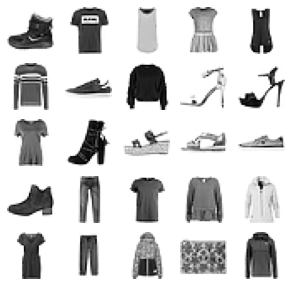

In [3]:
f, axarr = plt.subplots(5,5,figsize=[5,5])
for i in range(25):
    ax = axarr[int(i/5), int(i%5)]
    ax.imshow(X_train[i,:], cmap='Greys')
    ax.axis("off")
plt.show()

In [4]:
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

In [5]:
X_train = np.reshape(X_train, [X_train.shape[0], 784])
X_test = np.reshape(X_test, [X_test.shape[0], 784])
print('X_train: {}, y_train: {}, X_test: {}, y_test: {}'.format(X_train.shape,  y_train.shape, X_test.shape, y_test.shape))

X_train: (60000, 784), y_train: (60000,), X_test: (10000, 784), y_test: (10000,)


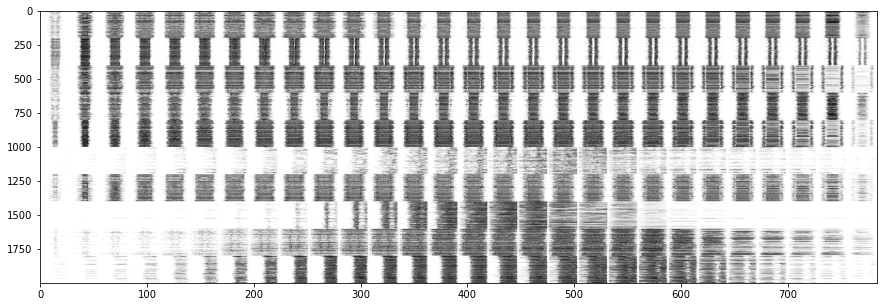

In [6]:
idx_lists = [np.where(i == y_train)[0] for i in set(y_train)]
concat_plot = np.vstack([X_train[idx[:200],:] for idx in idx_lists])
plt.figure(figsize=[15,5])
plt.imshow(concat_plot, aspect='auto', cmap='Greys')
# plt.axis("off")
plt.show()

In [7]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train_khot = enc.fit_transform([[i] for i in y_train]).A
y_test_khot = enc.fit_transform([[i] for i in y_test]).A

In [9]:
# import xgboost as xgb
# import time

# start = time.time()
# model=xgb.XGBClassifier(objective ="multi:softmax", colsample_bytree = 0.8, learning_rate = 0.1,
#                 max_depth = 6, alpha = .8, n_estimators = 10, num_class = 10, subsample = 0.8, eta = 0.08)
# model.fit(X_train, y_train)
# print(time.time() - start)

# model.score(X_test,y_test)

### XGBOOST results: accuracy = ~.84

In [10]:
batch_size = 128
epochs = 5
opt = RMSprop(lr=2e-3, decay=1e-5)
early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0, patience=2, verbose=0, mode='auto')
callbacks=[early_stop]

In [11]:
# input layer
model_input = Input(shape = [X_train.shape[1]])

# hidden layer
hidden = Dense(128,
                    activation='relu',
                    name='hidden')(model_input)
# fully connected layer
predictions = Dense(num_classes,
                    activation='softmax',
                    name='fc')(hidden)

# intialize model - define inputs and outputs
model = Model(inputs=model_input, outputs=predictions)

# compile model - define loss function and optimization method
model.compile(optimizer=opt,
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
hidden (Dense)               (None, 128)               100480    
_________________________________________________________________
fc (Dense)                   (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [12]:
## Clean up the TF session.
K.clear_session()

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [13]:
model.fit(X_train, y_train_khot, epochs=epochs, batch_size = 32, callbacks=callbacks)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 99us/sample - loss: 0.5056 - categorical_accuracy: 0.8195
Epoch 2/5
60000/60000 [==============================] - 6s 101us/sample - loss: 0.3920 - categorical_accuracy: 0.8618
Epoch 3/5
60000/60000 [==============================] - 5s 88us/sample - loss: 0.3691 - categorical_accuracy: 0.8727
Epoch 4/5
60000/60000 [==============================] - 5s 77us/sample - loss: 0.3536 - categorical_accuracy: 0.8796
Epoch 5/5
60000/60000 [==============================] - 5s 76us/sample - loss: 0.3479 - categorical_accuracy: 0.8842


In [14]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [16]:
# # Clean up the TF session.
# K.clear_session()

# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

In [17]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-3, decay=1e-5),
                    loss='categorical_crossentropy',
                    metrics=['categorical_accuracy'])

preds = model.predict(X_test)
print(preds.shape)

acc = np.equal(np.argmax(preds, 1), tf.argmax(y_test_khot, 1)).mean()

# loss, acc = loaded_model.evaluate(X_test, y_test_khot, num_classes)
print('\nTest accuracy: {0}'.format(acc))

(10000, 10)

Test accuracy: 0.8642
